# Imports


In [27]:
import os
from warnings import filterwarnings

filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

%matplotlib inline

In [28]:
DATA_DIR = "data"
FILE_NAME = "titanic.csv"
FILE_PATH = os.path.join(DATA_DIR, FILE_NAME)
FILE_URL = "https://biostat.app.vumc.org/wiki/pub/Main/DataSets/titanic3.csv"
RANDOM_SEED = 42

# Read Data


In [24]:
!wget -O $FILE_PATH $FILE_URL

df = pd.read_csv(FILE_PATH)
print(f"Records: {df.shape[0]}")
df.head()

--2024-02-17 14:46:31--  https://biostat.app.vumc.org/wiki/pub/Main/DataSets/titanic3.csv
Resolving biostat.app.vumc.org (biostat.app.vumc.org)... 160.129.29.79
Connecting to biostat.app.vumc.org (biostat.app.vumc.org)|160.129.29.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116752 (114K) [text/csv]
Saving to: ‘data/titanic.csv’

data/titanic.csv    100%[===================>] 114.02K  --.-KB/s    in 0.09s   

2024-02-17 14:46:31 (1.27 MB/s) - ‘data/titanic.csv’ saved [116752/116752]

Records: 1309


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


# Preprocess


In [73]:
df_c = pd.concat(
    [
        df,
        pd.get_dummies(df["sex"]).astype(np.float32),
        pd.get_dummies(df["embarked"], prefix="embark").astype(np.float32),
        pd.get_dummies(df["pclass"], prefix="class").astype(np.float32),
    ],
    axis=1,
).copy()
df_c["age"] = df_c["age"].fillna(df_c["age"].mean())
df_c["fare"] = df_c["fare"].fillna(df_c["fare"].mean())
df_c = df_c.drop(
    [
        "name",
        "ticket",
        "cabin",
        "boat",
        "body",
        "home.dest",
        "sex",
        "embarked",
        "pclass",
    ],
    axis=1,
)
df_c.head()

,survived,age,sibsp,parch,fare,female,male,embark_C,embark_Q,embark_S,class_1,class_2,class_3
0,1,29.00,0,0,211.3375,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1,0.92,1,2,151.5500,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0,2.00,1,2,151.5500,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0,30.00,1,2,151.5500,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0,25.00,1,2,151.5500,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [74]:
# Set random seed for reproducibility.
np.random.seed(RANDOM_SEED)

# Convert features and labels to numpy arrays.
labels = df_c["survived"].to_numpy()
df_c = df_c.drop(["survived"], axis=1)
feature_names = list(df_c.columns)
data = df_c.to_numpy()

# Separate training and test sets using
train_indices = np.random.choice(len(labels), int(0.7 * len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]

print(f"Train Features: {train_features.shape}, Train Labels: {train_labels.shape}")
print(f"Test Features: {test_features.shape}, Test Labels: {test_labels.shape}")

Train Features: (916, 12), Train Labels: (916,)
Test Features: (393, 12), Test Labels: (393,)


# Define Model


In [148]:
torch.manual_seed(RANDOM_SEED)


class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = self._create_linear_layer((12, 12))
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = self._create_linear_layer((12, 8))
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = self._create_linear_layer((8, 4))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.sigmoid1(x)
        x = self.linear2(x)
        x = self.sigmoid2(x)
        x = self.linear3(x)
        y = self.softmax(x)
        return y

    def _create_linear_layer(self, shape):
        layer = nn.Linear(shape[0], shape[1])
        nn.init.kaiming_uniform_(layer.weight)
        layer.weight.data, _ = layer.weight.data.sort()
        nn.init.zeros_(layer.bias)
        return layer

# Train


In [149]:
N_EPOCHS = 200
LEARNING_RATE = 0.01
LOG_INTERVAL = 20
BATCH_SIZE = 8

model = DNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_input_tensors = torch.from_numpy(train_features).type(torch.FloatTensor)
train_label_tensors = torch.from_numpy(train_labels)

dataset = TensorDataset(train_input_tensors, train_label_tensors)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(N_EPOCHS):
    for x, y in dataloader:
        output = model(x)
        loss = criterion(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % LOG_INTERVAL == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

torch.save(model.state_dict(), "models/model.pt")

Epoch: 0, Loss: 1.4388964176177979
Epoch: 20, Loss: 0.7454544305801392
Epoch: 40, Loss: 0.994373619556427
Epoch: 60, Loss: 0.9936782121658325
Epoch: 80, Loss: 0.9937340617179871
Epoch: 100, Loss: 0.9182221293449402
Epoch: 120, Loss: 0.7441040873527527
Epoch: 140, Loss: 1.4870160818099976
Epoch: 160, Loss: 0.7439229488372803
Epoch: 180, Loss: 0.7437108159065247


# Evaluate

In [150]:
out_probs = model(train_input_tensors).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes == train_labels) / len(train_labels))

Train Accuracy: 0.8264192139737991


In [151]:
test_input_tensors = torch.from_numpy(test_features).type(torch.FloatTensor)
out_probs = model(test_input_tensors).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.7989821882951654


# Interpret

## Primary Attribution

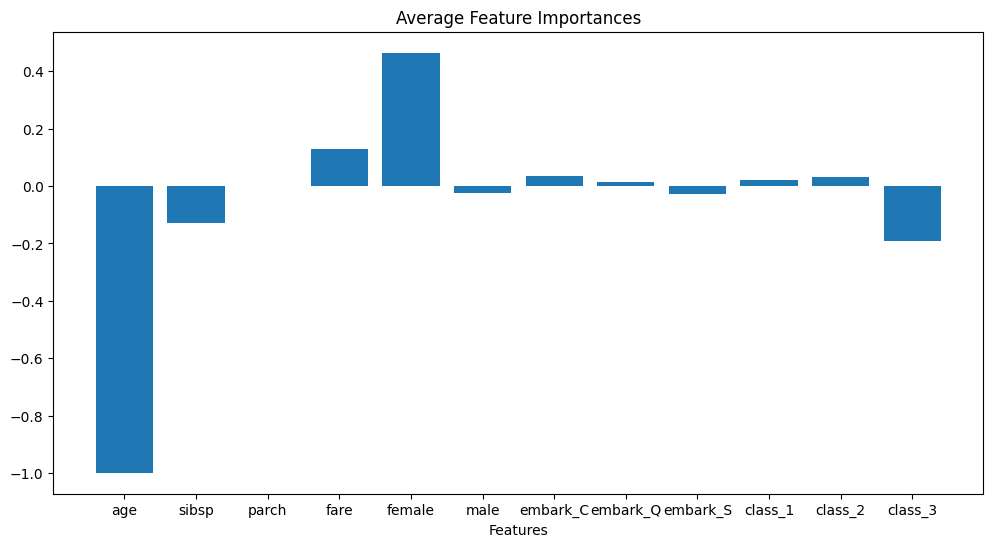

In [167]:
ig = IntegratedGradients(model)

test_input_tensors.requires_grad_()
attributions = (
    (ig.attribute(test_input_tensors, target=1, return_convergence_delta=True))[0]
    .detach()
    .numpy()
)


def visualize_importances(
    feature_names,
    importances,
    title="Average Feature Importances",
    plot=True,
    axis_title="Features",
):
    importances = np.mean(importances, axis=0)
    x_pos = np.arange(len(feature_names))
    if plot:
        plt.figure(figsize=(12, 6))
        plt.bar(x_pos, importances, align="center")
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
        plt.show()


visualize_importances(feature_names, attributions)

## Layer Attribution

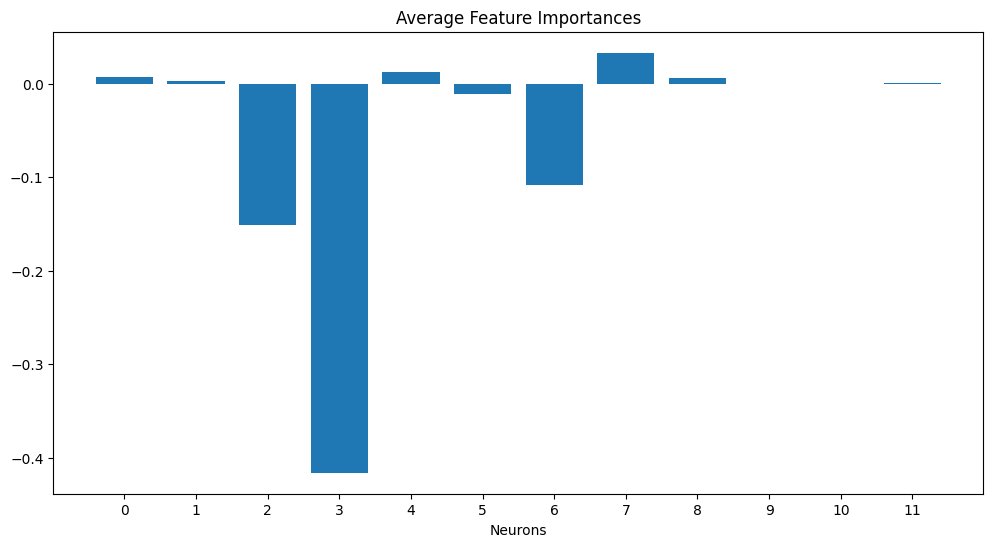

In [178]:
layer_conductance = LayerConductance(model, model.sigmoid1)
layer_conductance_values = (
    layer_conductance.attribute(test_input_tensors, target=1).detach().numpy()
)

visualize_importances(
    range(12),
    layer_conductance_values,
    axis_title="Neurons",
)

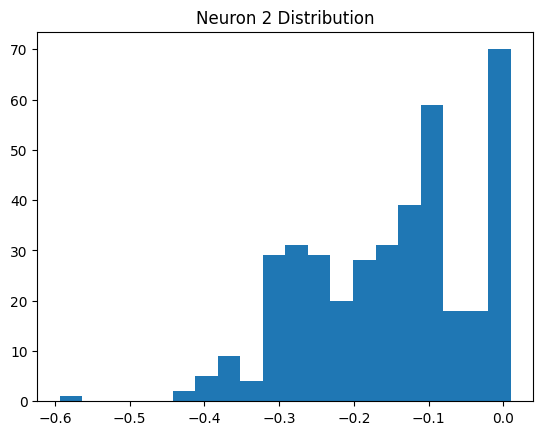

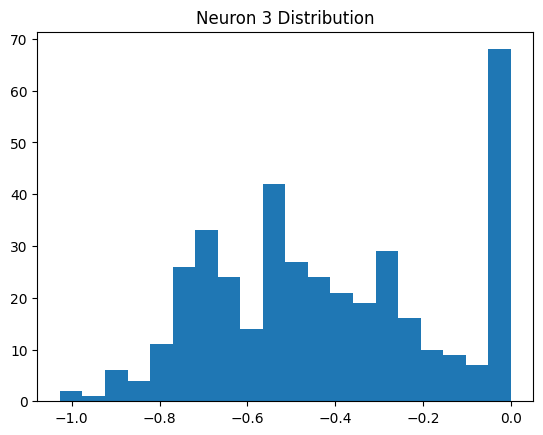

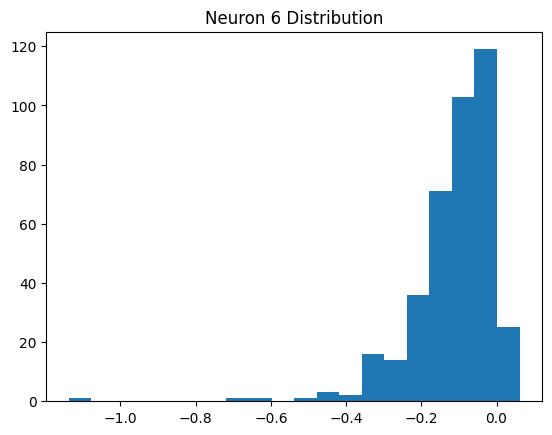

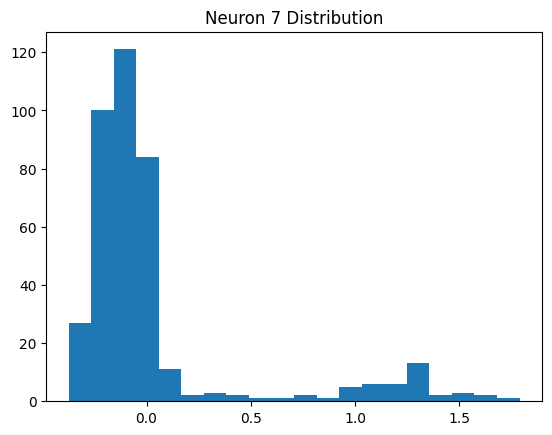

In [179]:
neurons = [2, 3, 6, 7]
hist_buckets = 20

for n in neurons:
    plt.hist(layer_conductance_values[:, n], hist_buckets)
    plt.title(f"Neuron {n} Distribution")
    plt.show()

## Neuron Attribution

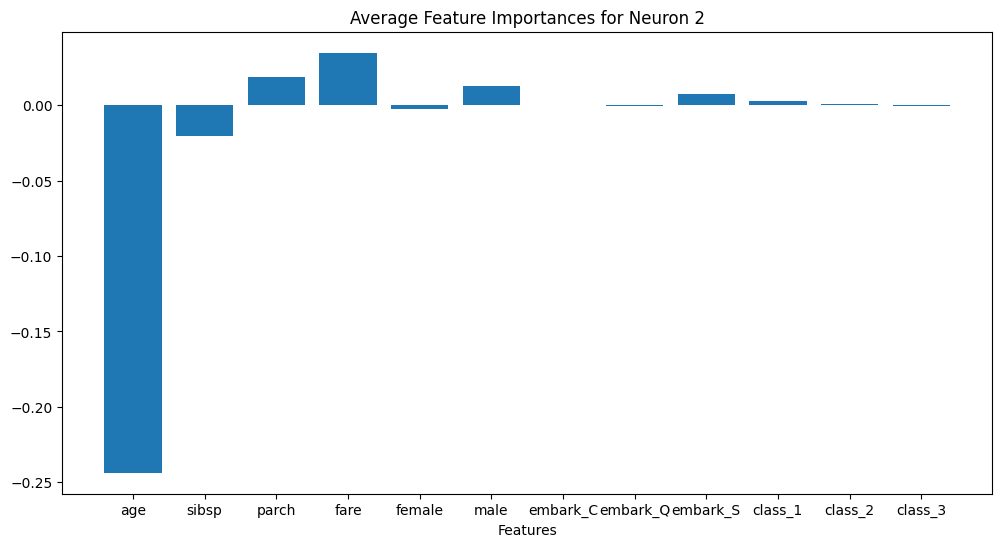

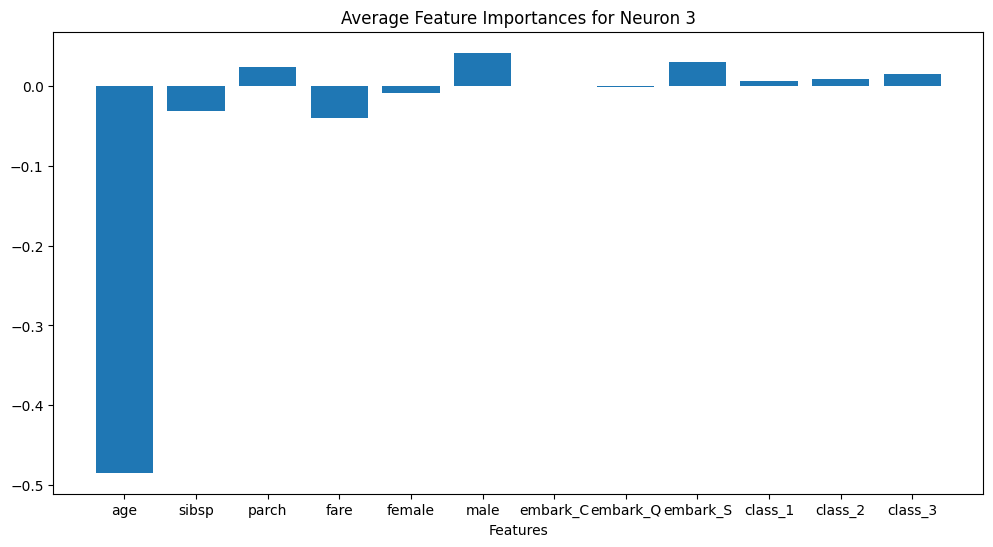

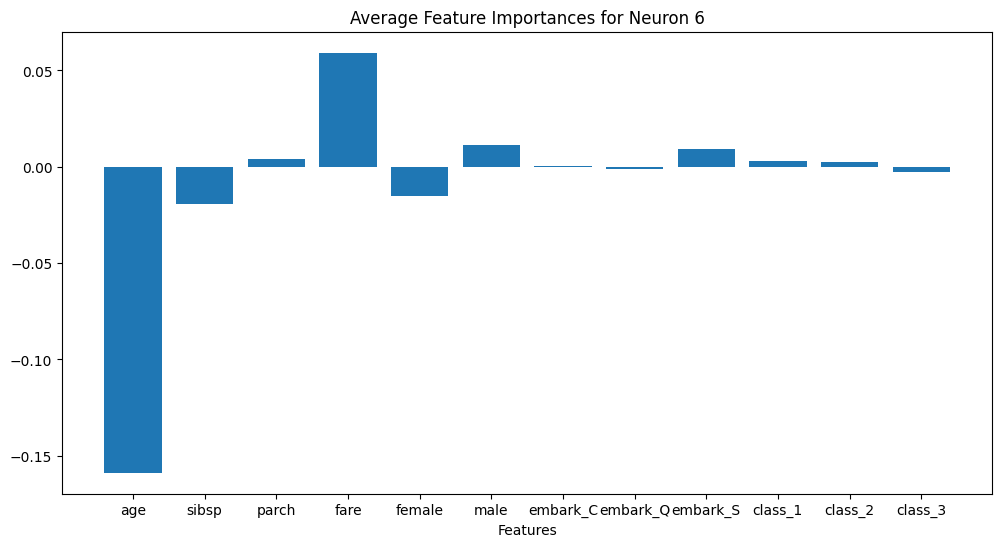

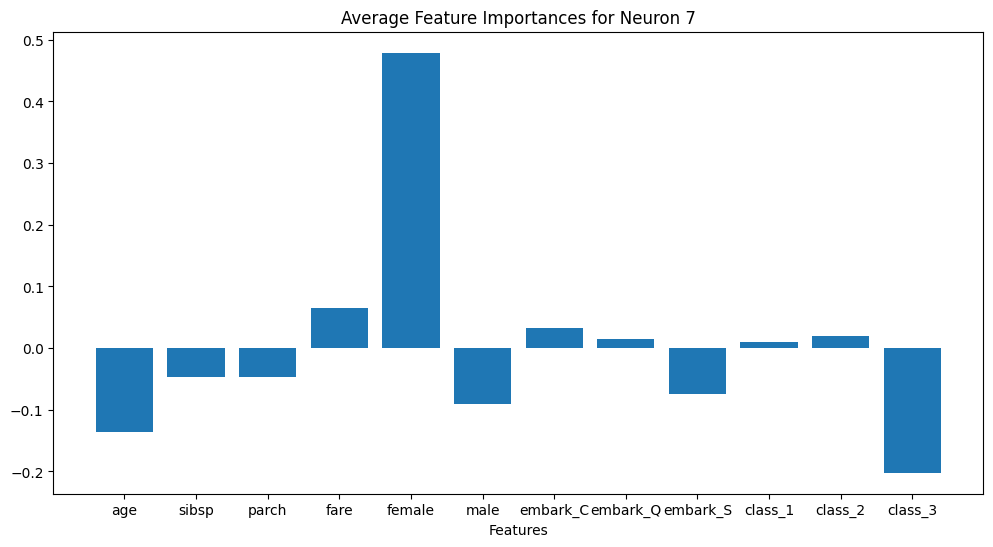

In [182]:
neuron_conductance = NeuronConductance(model, model.sigmoid1)

for n in neurons:
    neuron_conductance_values = (
        neuron_conductance.attribute(test_input_tensors, neuron_selector=n, target=1)
        .detach()
        .numpy()
    )
    visualize_importances(
        feature_names,
        neuron_conductance_values,
        title=f"Average Feature Importances for Neuron {n}",
    )